## Findings

In my exploration of implementing an autoencoder class, I made some interesting observations that influenced performance.

Firstly, I found that increasing the number of layers slightly improved performance. This suggests that a deeper architecture allows the autoencoder to capture more complex patterns in the data, leading to better reconstruction quality.

Additionally, I implemented batch normalization, which further enhanced performance. Batch normalization helps stabilize and speed up the training process by normalizing the inputs to each layer, leading to faster convergence and better generalization.

Moreover, I experimented with different values of learning rate, resulted as 0.005 is the best choice regarding to the performance and computing costs, which is even smaller than what i decided to set at CNN.

Overall, my findings suggest that for the autoencoder class, increasing the number of layers, implementing batch normalization, and decreasing learning rate at a certain level all play a valuable role in enhancing performance and reconstruction quality.


In [21]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [22]:
# Define transformations, normalizing and applying random horizontal flips

transform = transforms.Compose([
    transforms.ToTensor(),                      
    transforms.Normalize((0.5, 0.5, 0.5),      
                         (0.5, 0.5, 0.5)),
    transforms.RandomHorizontalFlip()           
])

In [23]:
# Downloading CIFAR-10 training and test dataset

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
#Implementing AutoEncoder model
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        # Batch normalization layers implemented
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(32),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(64),  
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(128),  
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(256),  
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(128),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(32),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encoder
        x = self.encoder(x)
        # Decoder
        x = self.decoder(x)
        return x

In [30]:
model = AutoEncoder()

# Defining Loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Choosing optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Some hyperparameters
num_epochs = 10
batch_size = 64

In [31]:
# Create DataLoader for training and testing dataset

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
# Initialize list to store training losses
training_losses = []

# Training phase
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, _ = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  
            running_loss = 0.0 # Reset running loss for the next interval

    # Calculate average training loss for the epoch
    average_loss = running_loss / len(train_loader)

    # Append average loss to the list
    training_losses.append(average_loss)

    # Print epoch and average loss
    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, num_epochs, average_loss))

print('Finished Training') 


Epoch [1/10], Loss: 0.1839
Epoch [2/10], Loss: 0.1542
Epoch [3/10], Loss: 0.1517
Epoch [4/10], Loss: 0.1503
Epoch [5/10], Loss: 0.1492
Epoch [6/10], Loss: 0.1486
Epoch [7/10], Loss: 0.1481
Epoch [8/10], Loss: 0.1476
Epoch [9/10], Loss: 0.1473
Epoch [10/10], Loss: 0.1468
Finished Training


In [33]:
#Testing 

model.eval()

total_loss = 0.0
num_batches = 0

# Initialize lists to store original and reconstructed images
original_images = []
reconstructed_images = []

with torch.no_grad():
    for data in test_loader:
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Forward pass
        outputs = model(inputs)

        # Calculate loss (Mean Squared Error)
        loss = criterion(outputs, inputs)

        # Accumulate total loss
        total_loss += loss.item()
        num_batches += 1

        # Append original and reconstructed images to lists for visualization
        original_images.append(inputs.cpu().numpy())
        reconstructed_images.append(outputs.cpu().numpy())


# Calculate average reconstruction error
average_loss = total_loss / num_batches
print("Average Reconstruction Error (MSE) on Testing Set:", average_loss)


Average Reconstruction Error (MSE) on Testing Set: 0.14317544687325787


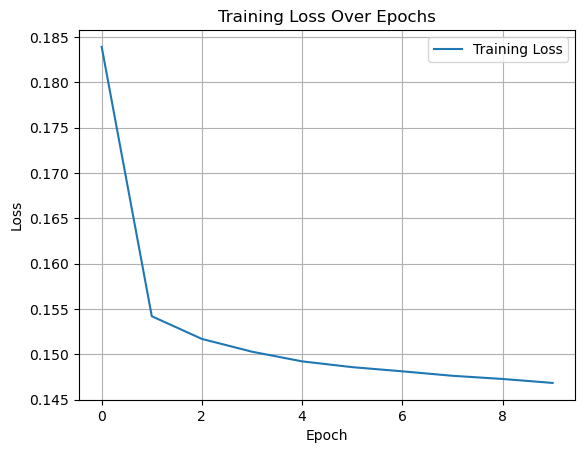

In [34]:
#Loss value/num_epoch graph

plt.plot(training_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [10]:


def visualize_encoded_representations_pca(model, data_loader, num_samples=1000):
    model.eval()

    # Initialize lists to store encoded representations
    encoded_features = []
    labels = []

    # Extract encoded features from data_loader
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if i * inputs.size(0) >= num_samples:
                break

            encoded = model.encoder(inputs)
            encoded = encoded.view(encoded.size(0), -1)  # Flatten the encoded features
            encoded_features.append(encoded.numpy())
            labels.extend(targets.numpy())

    encoded_features = np.concatenate(encoded_features, axis=0)

    # Perform PCA
    pca = PCA(n_components=2)

    # Fit and transform encoded features
    embedded_features = pca.fit_transform(encoded_features)

    # Plot embedded features
    plt.figure(figsize=(8, 6))
    for label in np.unique(labels):
        indices = np.where(np.array(labels) == label)
        plt.scatter(embedded_features[indices, 0], embedded_features[indices, 1], label=label)
    plt.title('Encoded Representations Visualization using PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


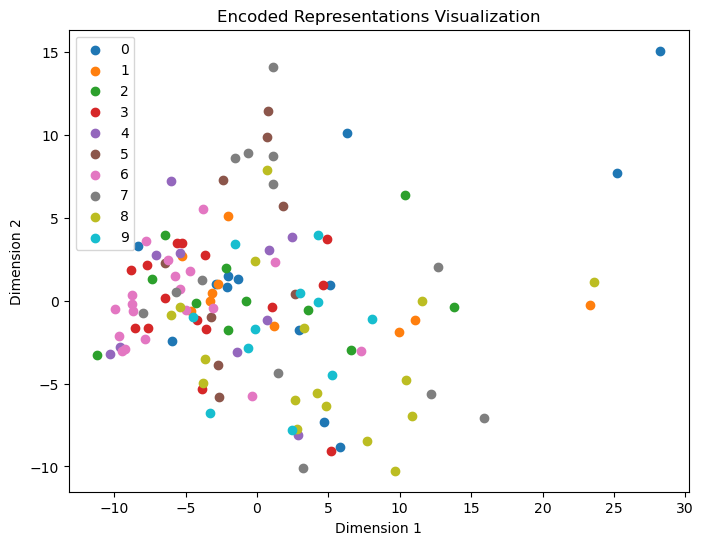

In [12]:
visualize_encoded_representations(model, test_loader, num_samples=100, method='PCA')

In [19]:

def visualize_reconstructions(model, data_loader, num_samples=5):
    model.eval()

    # Initialize lists to store original, encoded, and reconstructed images
    original_images = []
    encoded_images = []
    reconstructed_images = []

    # Extract original, encoded, and reconstructed images from data_loader
    with torch.no_grad():
        for i, (inputs, _) in enumerate(data_loader):
            if i == num_samples:
                break

            # Forward pass through autoencoder
            outputs = model(inputs)

            # Append original, encoded, and reconstructed images to lists
            original_images.append(inputs.cpu().numpy())
            encoded_images.append(model.encoder(inputs).cpu().numpy())
            reconstructed_images.append(outputs.cpu().numpy())

    # Convert lists to Numpy arrays
    original_images = np.concatenate(original_images, axis=0)
    encoded_images = np.concatenate(encoded_images, axis=0)
    reconstructed_images = np.concatenate(reconstructed_images, axis=0)

    # Plot original, encoded, and reconstructed images
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 15))
    for i in range(num_samples):
        # Original image
        axes[i, 0].imshow(np.transpose(original_images[i], (1, 2, 0)))
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Encoded image
        if len(encoded_images.shape) > 3:
            encoded_image = encoded_images[i].squeeze()
            if len(encoded_image.shape) > 2:
                encoded_image = encoded_image.mean(axis=0)  # Collapse multi-channel encoded image
        else:
            encoded_image = encoded_images[i].squeeze()
        axes[i, 1].imshow(encoded_image, cmap='hot')  # Assuming the encoded image is a single channel
        axes[i, 1].set_title('Encoded')
        axes[i, 1].axis('off')

        # Reconstructed image
        axes[i, 2].imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
        axes[i, 2].set_title('Reconstructed')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


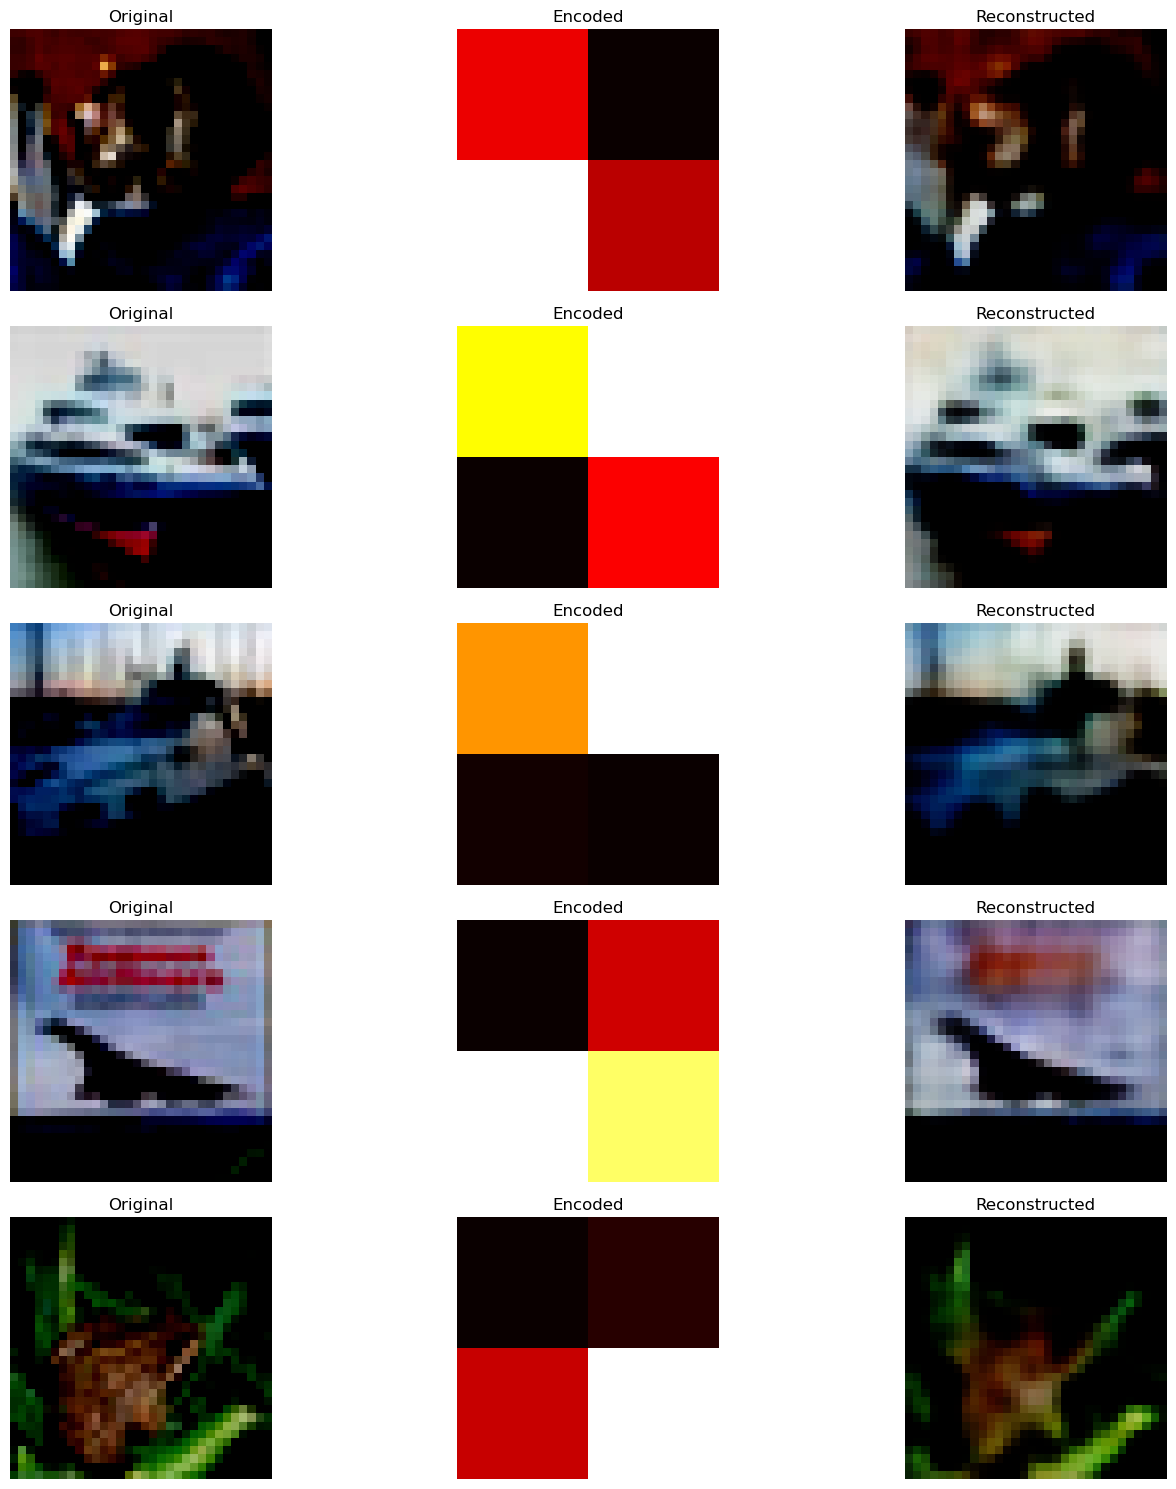

In [20]:

visualize_reconstructions(model, test_loader, num_samples=5)